In [45]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import scipy.io as sio
import scipy.sparse as scisparse
import matplotlib.pyplot as plt
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

NX, NY, NZ = 160, 160, 5
DX, DY, DZ = 250, 250, 40
sec2year   = 365.25 * 24 * 60 * 60
psi2pascal = 6894.76
co2_rho    = 686.5266
mega       = 1e6
mt2m3      = sec2year*co2_rho/mega/1e3

***

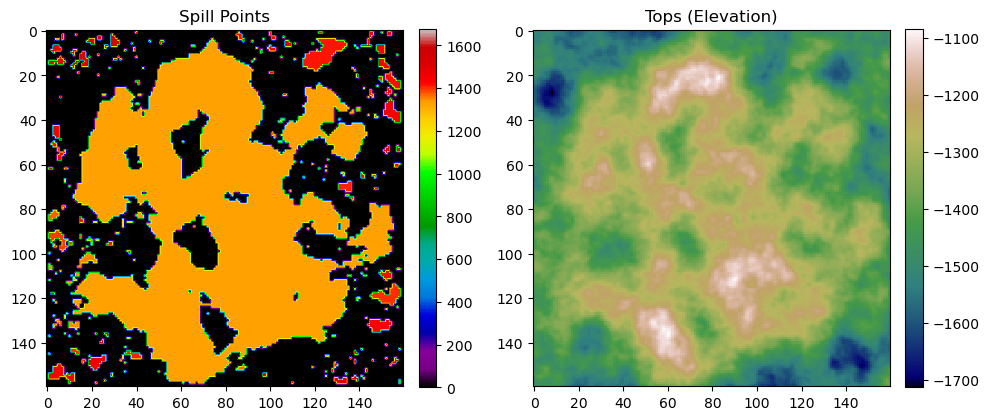

In [33]:
structuralTraps = sio.loadmat('structuralTraps.mat', simplify_cells=True)['ts']
grid = sio.loadmat('G.mat', simplify_cells=True)['G']
gridVE = sio.loadmat('Gt.mat', simplify_cells=True)['Gt']
tops2d = -gridVE['cells']['z'].reshape(NX,NY)

fig, axs = plt.subplots(1, 2, figsize=(10,5))
im1 = axs[0].imshow(structuralTraps['z_spill_loc'].reshape(NX,NY), cmap='nipy_spectral')
im2 = axs[1].imshow(tops2d, cmap='gist_earth', interpolation='none')
[plt.colorbar(i, pad=0.04, fraction=0.046) for i in [im1, im2]]
[a.set(title=['Spill Points', 'Tops (Elevation)'][i]) for i,a in enumerate(axs)]
plt.tight_layout()
plt.show()

In [12]:
sample = 313
dd = sio.loadmat('states/states_{}.mat'.format(sample), simplify_cells=True)['var']
ww = sio.loadmat('well_locs/well_locs_{}.mat'.format(sample), simplify_cells=True)['var'] - 1
cc = sio.loadmat('controls/controls_{}.mat'.format(sample), simplify_cells=True)['var'] * sec2year * co2_rho / 1e3 / mega

if len(cc.shape) == 1:
    cc = cc.reshape(1, -1)
if len(ww.shape) == 1:
    ww = ww.reshape(1, -1)

print(dd[0].keys())

dict_keys(['pressure', 's', 's3d', 't', 'dT', 'wellSol', 'totVol', 'vol', 'freeVol', 'trappedVol', 'leakedVol'])


In [13]:
totVol = []
vol = []
freeVol = []
trappedVol = []
leakedVol = []
timesteps = []

for i in tqdm(range(1, 60)):
    d = dd[i]
    totVol.append(d['totVol']/mt2m3)
    vol.append(d['vol']/mt2m3)
    freeVol.append(d['freeVol']/mt2m3)
    trappedVol.append(d['trappedVol']/mt2m3)
    leakedVol.append(d['leakedVol']/mt2m3)
    timesteps.append(d['t'])

totVol = np.array(totVol)
vol = np.array(vol)
freeVol = np.array(freeVol)
trappedVol = np.array(trappedVol)
leakedVol = np.array(leakedVol)
timesteps = np.array(timesteps)

100%|██████████| 59/59 [00:00<00:00, 273743.29it/s]


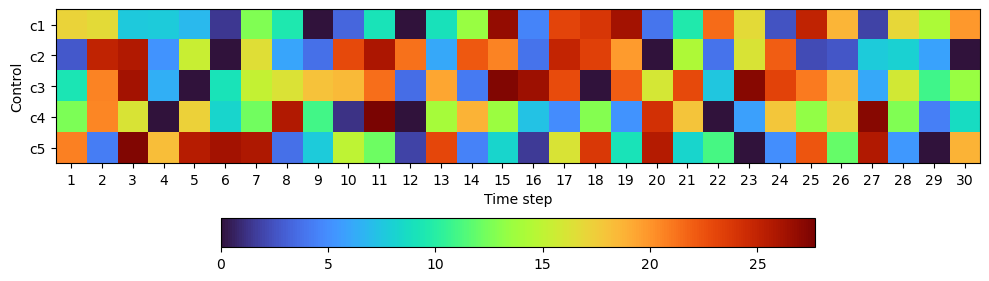

In [22]:
fig = plt.figure(figsize=(10,7))
ax  = fig.add_subplot(111)
im = ax.imshow(cc, cmap='turbo', interpolation='none')
ax.set(yticks=range(cc.shape[0]), yticklabels=['c{}'.format(i) for i in range(1, cc.shape[0]+1)],
       xticks=range(cc.shape[1]), xticklabels=range(1, cc.shape[1]+1),
       xlabel='Time step', ylabel='Control')
plt.colorbar(im, ax=ax, orientation='horizontal', pad=0.084, fraction=0.046)
plt.tight_layout()
plt.show()

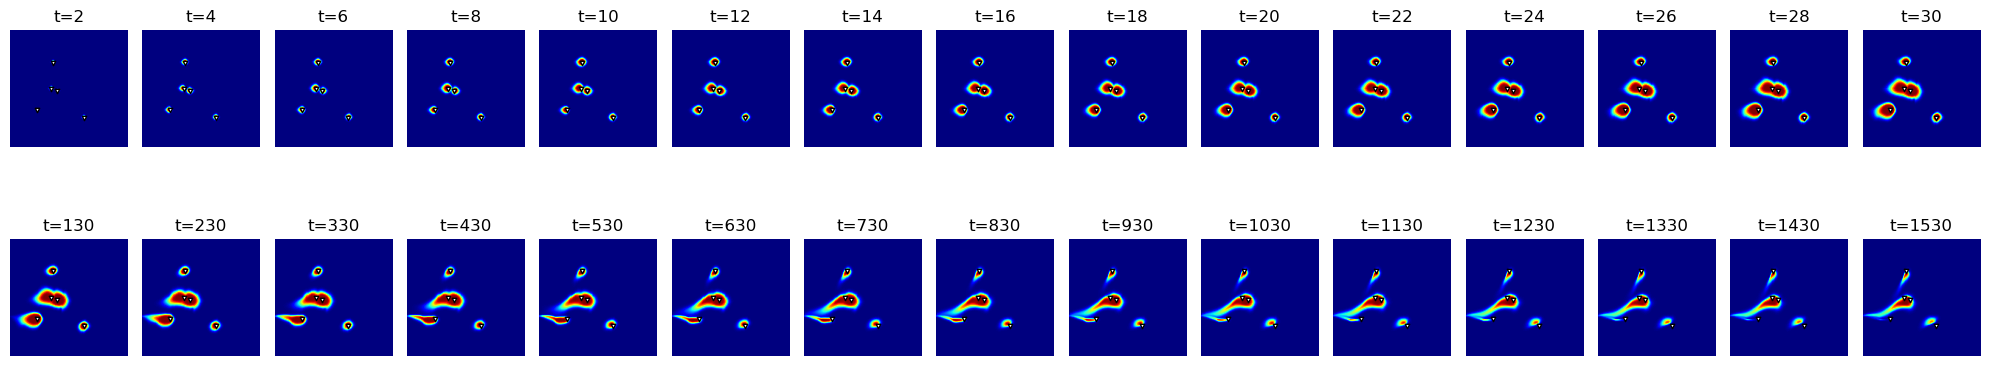

In [15]:
plt.figure(figsize=(20,5))
for i in range(30):
    plt.subplot(2, 15, i+1)
    s = dd[i*2]['s'].reshape(NX,NY) 
    p = dd[i*2]['pressure'].reshape(NX,NY) / psi2pascal
    plt.imshow(s, cmap='jet')
    plt.scatter(ww[:,0], ww[:,1], c='w', edgecolor='k', s=10, marker='v')
    plt.axis('off')
    plt.title('t={}'.format(dd[i*2+1]['t']))
plt.tight_layout()
plt.show()

In [27]:
sat = np.zeros((60, NX, NY))

for i in range(60):
    sat[i] = dd[i]['s'].reshape(NX,NY)

In [31]:
np.sum(sat[10] * )

556.9579296088659

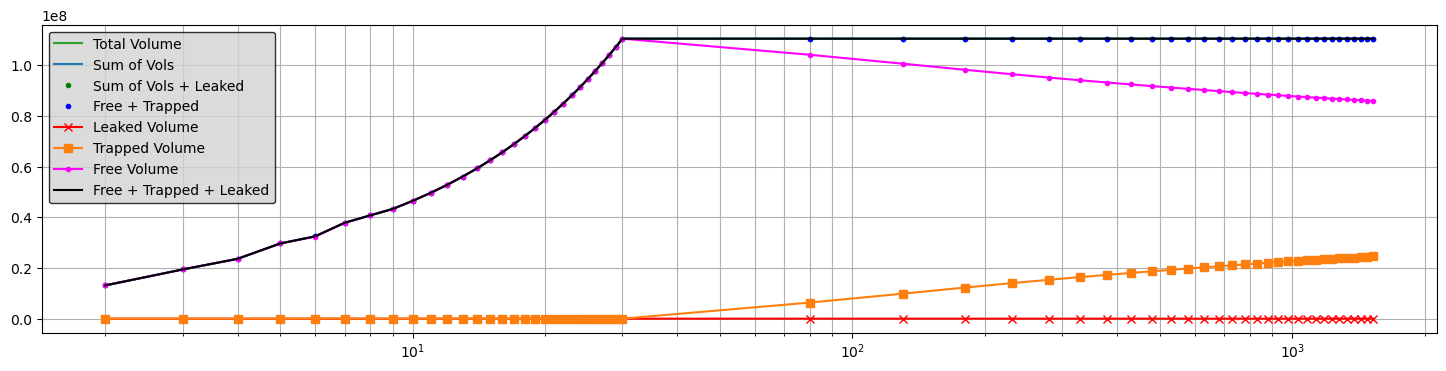

In [256]:
trapped_labels = ['residual (traps)', 'residual', 'free (residual)', 'moveable', 'free plume', 'leaked']

plt.figure(figsize=(18,4))

plt.plot(timesteps, totVol, label='Total Volume', c='tab:green')
plt.plot(timesteps, np.sum(vol, 1), label='Sum of Vols', c='tab:blue')

plt.plot(timesteps, np.sum(vol,1)+leakedVol, label='Sum of Vols + Leaked', ls='', marker='.', c='g')
plt.plot(timesteps, np.sum([freeVol, trappedVol], 0), label='Free + Trapped', ls='', marker='.', c='b')

plt.plot(timesteps, leakedVol, label='Leaked Volume', c='r', marker='x')
plt.plot(timesteps, trappedVol, label='Trapped Volume', c='tab:orange', marker='s')
plt.plot(timesteps, freeVol, label='Free Volume', c='magenta', marker='.')

plt.plot(timesteps, freeVol+trappedVol+leakedVol, c='k', label='Free + Trapped + Leaked')

# vols = np.hstack([vol, leakedVol.reshape(-1,1)])
# for k in range(6):
#     plt.plot(timesteps, vols[:,k], label=trapped_labels[k], ls='-.', c='C{}'.format(k+4))

plt.legend(facecolor='lightgrey', edgecolor='k', loc='upper left')
plt.xscale('log')
plt.grid(True, which='both')

plt.show()